In [1]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import glob
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras_metrics import recall, precision
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [42]:
WINDOW_SIZE = 60
TRAIN_TEST_SPLIT = 1. # set to 0.1 for other stocks data testing

In [43]:
def preprocess(fname, cut=0):
    print("preparing data...")
    df = pd.read_csv(fname)[-cut:]
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    signals = np.array(df["close"] - df["close"].shift() > 0).astype(int)[1:]
    df = df[:-1]
    indicators = df.copy()
    print("calculating indicators...")
    indicators['true_signals'] = signals
    indicators['KAMA'] = TA.KAMA(df)
    indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    indicators['TEMA20'] = TA.TEMA(df, period=20)
    indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA40'] = TA.EMA(df, period=40)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    indicators['RSI7'] = TA.RSI(df, period=7)
    indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    indicators['ATR'] = TA.ATR(df)
    print("assigining indicators...")
    indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    signals = np.array(indicators.pop('true_signals'))
    headers = list(indicators)
    
    print("splitting data...")
    prices = indicators.close.copy()[WINDOW_SIZE-1:-1]
    indicators = np.array([normalize(indicators[i:i+WINDOW_SIZE], axis=0, norm='max')
                  for i in range(len(indicators) - WINDOW_SIZE)])
    signals = signals[WINDOW_SIZE-1:-1]
    
    if len(indicators) != len(signals):
        raise RuntimeError("len(indicators) != len(signals)")
    if len(signals) != len(prices):
        raise RuntimeError("len(signals)(%s) != len(prices)(%s)" % (len(signals), len(prices)))
        
    split_index = int(TRAIN_TEST_SPLIT*len(prices))
    data_train, signals_train, prices_train = indicators[:split_index], signals[:split_index], prices[:split_index]
    data_test, signals_test, prices_test = indicators[split_index:], signals[split_index:], prices[split_index:]
    print("done!")
    
    return data_train, signals_train, prices_train, data_test, signals_test, prices_test, headers

In [47]:
data_train, signals_train, prices_train, data_test, signals_test, prices_test, headers = preprocess("./quotes/sbrf7.csv")

preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!


In [88]:
test = SelectKBest(k=6)
fit = test.fit(data_train[:,-1], signals_train)
np.array(headers)[fit.get_support()]

array(['volume', 'AO', 'RSI14', 'RSI7', 'RSI21', 'ATR'], dtype='<U7')

In [63]:
test = ExtraTreesClassifier()
test.fit(data_train[:,-1], signals_train)

C:\Users\Admin\.conda\envs\neuro\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [76]:
np.sort(np.stack((test.feature_importances_, headers), axis=-1), axis=0)[::-1][:12]

array([['0.05059020121368428', 'volume'],
       ['0.04895089454397813', 'signal'],
       ['0.04868332546534843', 'open'],
       ['0.04867261595539607', 'low'],
       ['0.04772873104920038', 'high'],
       ['0.047029888416966356', 'close'],
       ['0.045841339925612234', 'TEMA5'],
       ['0.04536926171549877', 'TEMA20'],
       ['0.04436879484990305', 'SIGNAL'],
       ['0.043942716889218456', 'RSI7'],
       ['0.04372535522017671', 'RSI21'],
       ['0.04338246100195554', 'RSI14']], dtype='<U32')

In [80]:
test.predict(data_train[:,-1])

array([1, 0, 0, ..., 1, 1, 0])

In [81]:
signals_train

array([1, 0, 0, ..., 1, 1, 0])

In [93]:
test = PCA(n_components=8)

In [96]:
features = test.fit(data_train[:,-1]).transform(data_train[:,-1])

In [98]:
features.shape

(46246, 8)

In [10]:
sber = pd.read_csv('./quotes/sbrf8.csv')
gold = pd.read_csv('./quotes/gold8.csv')

W0422 21:03:00.871185 22420 legend.py:1282] No handles with labels found to put in legend.


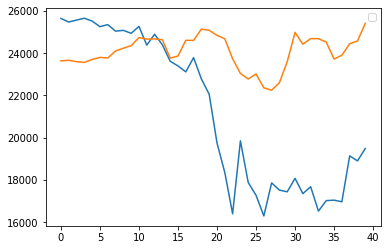

In [25]:
plt.plot(list(sber['<CLOSE>'].tail(40)))
plt.plot(np.multiply(list(gold['<CLOSE>'].tail(40)), 15))
plt.legend()

Text(0, 0.5, 'Цена, руб')

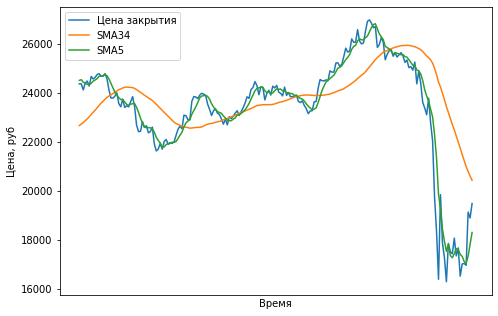

In [68]:
sber.columns = ['d', 't', 'open', 'high', 'low', 'close', 'volume']
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.plot(sber['close'].tail(200), label='Цена закрытия')
ax.plot(TA.SMA(sber, period=34, column='close').tail(200), label='SMA34')
ax.plot(TA.SMA(sber, period=5, column='close').tail(200), label='SMA5')
#ax.plot(TA.AO(sber).tail(200), label='SMA')
ax.legend()
ax.set_xticks([])
ax.set_xlabel("Время")
ax.set_ylabel("Цена, руб")

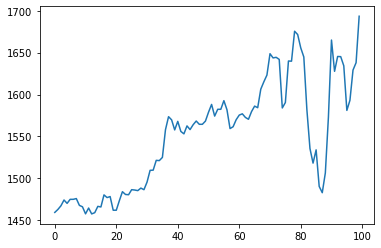

In [28]:
plt.plot(list(gold['<CLOSE>'].tail(100)))